# 성능 개선 
feature engineering + Optuna + rolling CV

In [17]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import joblib
import lightgbm as lgb

BASE = Path("..").resolve() / "data_pipeline"

TRAIN_CSV   = BASE / "features_train.csv"
TEST_CSV    = BASE / "features_test.csv"
PRED_CSV    = BASE / "predictions.csv"
MODEL_PATH  = BASE / "lightgbm_model.pkl"
FEATS_JSON  = BASE / "lightgbm_features.json"

print("DATA DIR:", BASE)
print("Files exist?",
      TRAIN_CSV.exists(),
      TEST_CSV.exists(),
      PRED_CSV.exists(),
      MODEL_PATH.exists(),
      FEATS_JSON.exists()
)


DATA DIR: C:\Users\chosw\ORDER101_SMART_ORDERRR\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline
Files exist? True True True True True


In [2]:
pip install optuna

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached greenlet-3.2.4-cp313-cp313-win_amd64.whl.metadata (4.2 kB)
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ------------------- -------------------- 1.0/2.1 MB 5.7 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 5.9 MB/s  0:00:00
Using cached greenlet-3.2.4-cp313-cp313-win_amd64.whl (299 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)

   ---------------------------------------- 0/7 [tqdm]
   ---------------------------------------- 0/7 [tqdm]
   ---------------------------------------- 0/7 [tqdm]
   ---------------------------------------- 0/7 [tqdm]
   ---------------------------------------- 0/7 [tqdm]
   ---------------------------------------- 0/7 [tqdm]
   ----- ---------------------------------- 1/7 [Mako]
   ----- ---------------------------------- 1/7 [Mako]
   ----- ---------------------------------- 1/7 [Mako]
   ----- -----------------------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
train = pd.read_csv(TRAIN_CSV, parse_dates=["target_date"])
test  = pd.read_csv(TEST_CSV,  parse_dates=["target_date"])

print("train shape:", train.shape)
print("test shape :", test.shape)
display(train.head(3))

with open(FEATS_JSON, "r", encoding="utf-8") as f:
    features = json.load(f)

print("\n# of features:", len(features))
print(features)

model = joblib.load(MODEL_PATH)
print("\nLoaded model type:", type(model))
print("best_iteration_:", getattr(model, "best_iteration_", None))

pred_df = pd.read_csv(PRED_CSV, parse_dates=["target_date"])
print("\npredictions.csv shape:", pred_df.shape)
display(pred_df.head(3))


train shape: (266500, 43)
test shape : (33800, 43)


,target_date,warehouse_id,store_id,sku_id,region,cat_low,actual_order_qty,lag_1,lag_2,lag_4,...,back_to_school,avg_temp_c_ma4,cdd_ma4,hdd_ma4,precip_mm_ma4,himart_sales_index_ma4,holiday_index_ma4,marketing_score_ma4,y,split
0,2016-02-29,1,1,AC-CAR-16P-2024,본사창고,에어컨,60,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,train
1,2016-03-07,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,60.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
2,2016-03-14,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,60.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train



# of features: 33
['lag_1', 'lag_2', 'lag_4', 'lag_8', 'lag_12', 'ma_4', 'ma_8', 'ma_12', 'year', 'weekofyear', 'month', 'sin_week', 'cos_week', 'avg_temp_c', 'cdd', 'hdd', 'precip_mm', 'heat_wave', 'cold_wave', 'himart_sales_krw', 'himart_sales_index', 'holiday_index', 'marketing_score', 'seasonal_peak', 'back_to_school', 'avg_temp_c_ma4', 'cdd_ma4', 'hdd_ma4', 'precip_mm_ma4', 'himart_sales_index_ma4', 'holiday_index_ma4', 'marketing_score_ma4', 'promo_flag_prev']

Loaded model type: <class 'lightgbm.sklearn.LGBMRegressor'>
best_iteration_: 823

predictions.csv shape: (33800, 7)


,warehouse_id,store_id,sku_id,region,target_date,y,y_pred
0,1,1,AC-CAR-16P-2024,본사창고,2024-01-08,58.0,61
1,1,1,AC-CAR-16P-2024,본사창고,2024-01-15,60.0,60
2,1,1,AC-CAR-16P-2024,본사창고,2024-01-22,61.0,60


## 지표 함수 정의 & 전체 성능 재확인

In [19]:
from sklearn.metrics import mean_absolute_error

def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff  = np.abs(y_true - y_pred)
    denom = np.where(denom == 0, 1.0, denom)
    return np.mean(diff / denom) * 100.0

def mape(y_true, y_pred):
    denom = np.where(y_true == 0, 1.0, y_true)
    return (np.abs((y_true - y_pred) / denom)).mean() * 100.0

y_true = pred_df["y"].values
y_pred = pred_df["y_pred"].values

mae   = mean_absolute_error(y_true, y_pred)
mape_ = mape(y_true, y_pred)
smape_= smape(y_true, y_pred)

print(f"TEST MAE = {mae:,.3f}")
print(f"TEST MAPE = {mape_:,.2f}%")
print(f"TEST SMAPE = {smape_:,.2f}%")
print("n =", len(y_true))


TEST MAE = 14.967
TEST MAPE = 76.07%
TEST SMAPE = 16.79%
n = 33800


## Feature Importance (split 기준)

Feature importance (split / 횟수 기준)

In [20]:
# LGBMRegressor는 내부에 booster_를 가지고 있음
booster = model.booster_

imp_split = booster.feature_importance(importance_type="split")
feat_names = booster.feature_name()

imp_split_df = (
    pd.DataFrame({"feature": feat_names, "importance_split": imp_split})
      .sort_values("importance_split", ascending=False)
      .reset_index(drop=True)
)

imp_split_df.head(20)


,feature,importance_split
0,lag_1,3427
1,weekofyear,2785
2,sin_week,1737
3,year,1601
4,month,1578
5,lag_2,1466
6,ma_4,1252
7,cos_week,1169
8,lag_12,1022
9,lag_4,1005


상위 20개 피처 bar plot (split 기준)

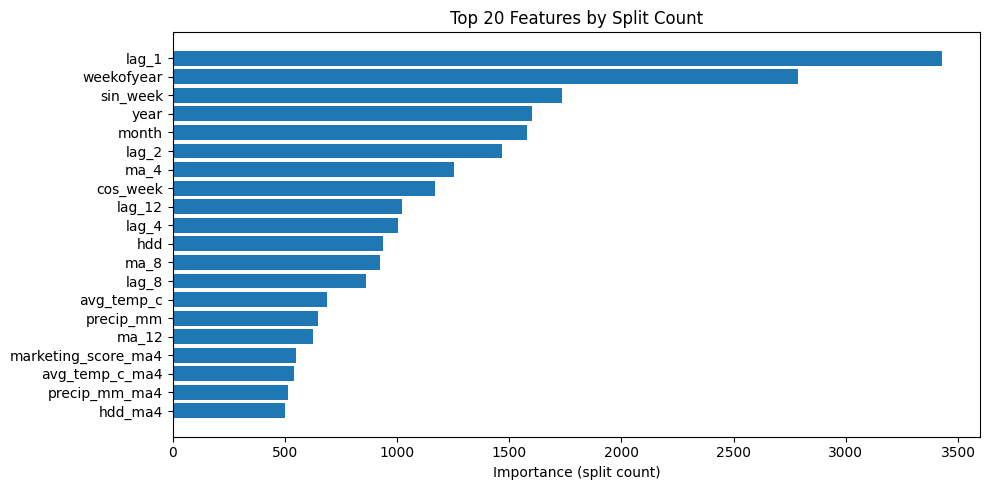

In [21]:
top_n = 20
top_split = imp_split_df.head(top_n)

plt.figure(figsize=(10, 5))
plt.barh(top_split["feature"][::-1], top_split["importance_split"][::-1])
plt.xlabel("Importance (split count)")
plt.title(f"Top {top_n} Features by Split Count")
plt.tight_layout()
plt.show()


Feature Importance (gain 기준)

In [22]:
imp_gain = booster.feature_importance(importance_type="gain")

imp_gain_df = (
    pd.DataFrame({"feature": feat_names, "importance_gain": imp_gain})
      .sort_values("importance_gain", ascending=False)
      .reset_index(drop=True)
)

imp_gain_df.head(20)


,feature,importance_gain
0,lag_1,2.106899e+08
1,ma_4,9.997684e+07
2,lag_2,6.986680e+07
3,year,6.768601e+07
4,ma_8,1.280410e+07
5,lag_4,4.172460e+06
6,month,3.256420e+06
7,weekofyear,3.103556e+06
8,sin_week,1.119334e+06
9,cos_week,1.072393e+06


상위 20개 피처 bar plot (gain 기준)

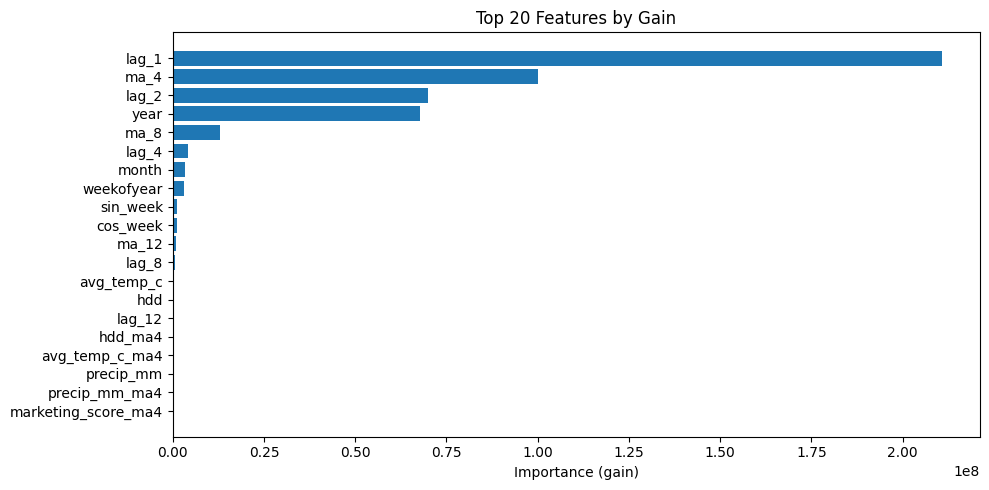

In [25]:
top_n = 20
top_gain = imp_gain_df.head(top_n)

plt.figure(figsize=(10, 5))
plt.barh(top_gain["feature"][::-1], top_gain["importance_gain"][::-1])
plt.xlabel("Importance (gain)")
plt.title(f"Top {top_n} Features by Gain")
plt.tight_layout()
plt.show()


## test + feature + prediction

In [26]:
test_keys = ["warehouse_id", "store_id", "sku_id", "region", "target_date"]

keys_in_both = [c for c in test_keys if c in test.columns and c in pred_df.columns]
print("merge keys:", keys_in_both)

test_merged = pd.merge(
    test,
    pred_df,
    on=keys_in_both + ["y"],  
    how="inner",
    validate="one_to_one"
)

print("test_merged shape:", test_merged.shape)
test_merged[["target_date", "sku_id", "y", "y_pred"]].head(5)


merge keys: ['warehouse_id', 'store_id', 'sku_id', 'region', 'target_date']
test_merged shape: (33800, 44)


,target_date,sku_id,y,y_pred
0,2024-01-08,AC-CAR-16P-2024,58.0,61
1,2024-01-15,AC-CAR-16P-2024,60.0,60
2,2024-01-22,AC-CAR-16P-2024,61.0,60
3,2024-01-29,AC-CAR-16P-2024,54.0,63
4,2024-02-05,AC-CAR-16P-2024,63.0,60


에러 컬럼 추가

In [27]:
test_merged["error"]      = test_merged["y_pred"] - test_merged["y"]
test_merged["abs_error"]  = test_merged["error"].abs()
test_merged["abs_pct_err"]= test_merged["abs_error"] / test_merged["y"].replace(0, 1)

test_merged[["y", "y_pred", "error", "abs_error"]].head(5)


,y,y_pred,error,abs_error
0,58.0,61,3.0,3.0
1,60.0,60,0.0,0.0
2,61.0,60,-1.0,1.0
3,54.0,63,9.0,9.0
4,63.0,60,-3.0,3.0


## 실제/예측 시계열(총 수요) 비교

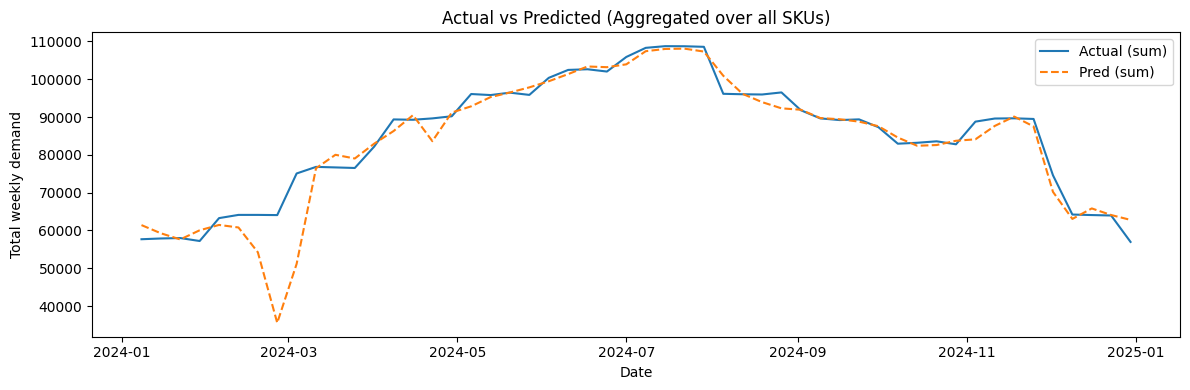

,target_date,y,y_pred
0,2024-01-08,57676.0,61414
1,2024-01-15,57874.0,59250
2,2024-01-22,57989.0,57622
3,2024-01-29,57205.0,60043
4,2024-02-05,63264.0,61459


In [28]:
ts = (
    test_merged
    .groupby("target_date", as_index=False)[["y", "y_pred"]]
    .sum()
    .sort_values("target_date")
)

plt.figure(figsize=(12, 4))
plt.plot(ts["target_date"], ts["y"], label="Actual (sum)")
plt.plot(ts["target_date"], ts["y_pred"], label="Pred (sum)", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Total weekly demand")
plt.title("Actual vs Predicted (Aggregated over all SKUs)")
plt.legend()
plt.tight_layout()
plt.show()

ts.head()


## 카테고리 기준 에러 분석

In [29]:
def agg_metrics(df):
    y = df["y"].values
    p = df["y_pred"].values
    return pd.Series({
        "cnt": len(df),
        "mae":  mean_absolute_error(y, p),
        "mape": mape(y, p),
        "smape": smape(y, p),
        "avg_actual": df["y"].mean()
    })

by_cat = (
    test_merged
    .groupby("cat_low")
    .apply(agg_metrics)
    .sort_values("mae", ascending=False)
)

by_cat.head(20)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_11056\2673397132.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_metrics)


,cnt,mae,mape,smape,avg_actual
cat_low,,,,,
믹서기,1040.0,35.550962,807.562971,25.164309,331.985577
스마트워치,1040.0,29.835577,9.451834,9.740994,331.894231
토스터기,1040.0,25.665385,9.949143,10.309405,273.870192
식기세척기,1560.0,23.660897,218.135478,19.528464,192.796795
데스크탑,1560.0,22.903846,10.479399,10.856221,230.930769
전자레인지,2080.0,20.255769,34.280348,22.431109,151.827404
오븐,1560.0,20.225641,249.431742,22.961128,134.573077
커피머신,1560.0,18.552564,10.627604,11.062957,183.221795
노트북,1560.0,15.885256,11.009846,11.445201,153.997436


##  MAE 기준 상위 10개 카테고리 bar plot

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_11056\431288310.py:8: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_11056\431288310.py:8: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_11056\431288310.py:8: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_11056\431288310.py:8: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_11056\431288310.py:8: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_11056\431288310.py:8:

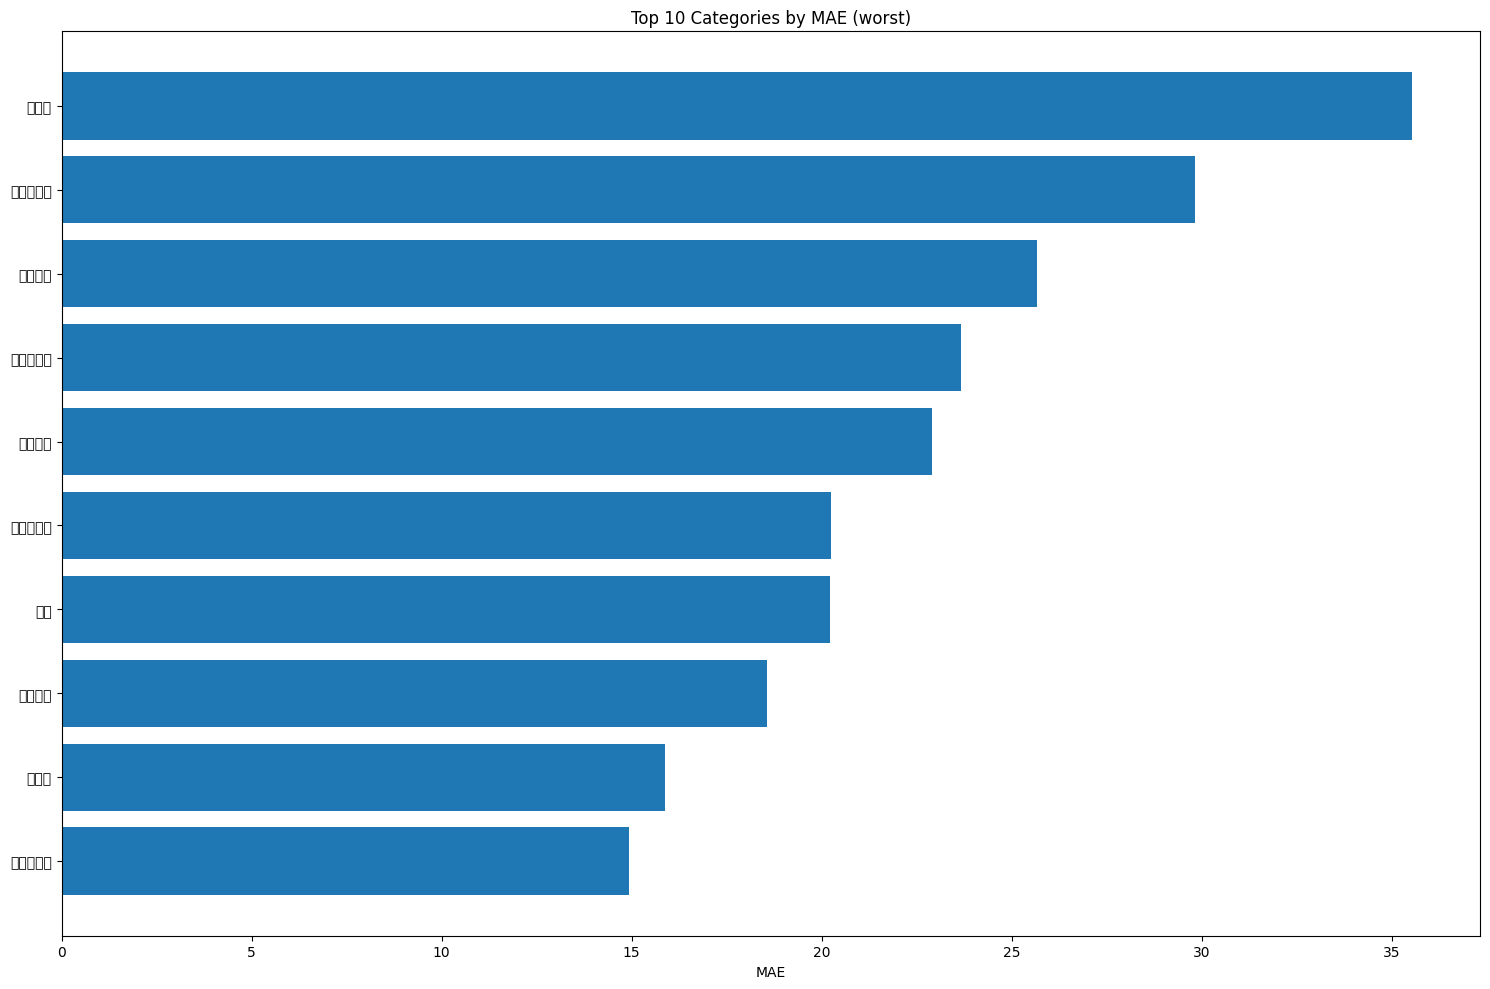

In [31]:
top_n = 10
top_cat = by_cat.head(top_n).reset_index()

plt.figure(figsize=(15, 10))
plt.barh(top_cat["cat_low"][::-1], top_cat["mae"][::-1])
plt.xlabel("MAE")
plt.title(f"Top {top_n} Categories by MAE (worst)")
plt.tight_layout()
plt.show()

## 시간(weekofyear) 기준 에러 분석

In [32]:
tmp = test_merged.copy()
tmp["weekofyear"] = tmp["target_date"].dt.isocalendar().week.astype(int)

by_week = (
    tmp.groupby("weekofyear")
       .apply(lambda df: pd.Series({
           "cnt": len(df),
           "mae": mean_absolute_error(df["y"], df["y_pred"]),
           "mape": mape(df["y"].values, df["y_pred"].values),
           "smape": smape(df["y"].values, df["y_pred"].values),
       }))
       .reset_index()
)

by_week.head()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_11056\588774154.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: pd.Series({


,weekofyear,cnt,mae,mape,smape
0,1,650.0,11.704615,17.162368,17.166157
1,2,650.0,9.753846,202.277094,47.805497
2,3,650.0,18.353846,418.295280,24.303259
3,4,650.0,12.743077,79.393100,15.950678
4,5,650.0,11.009231,23.935012,13.120956


## weekofyear vs MAE 라인 플롯

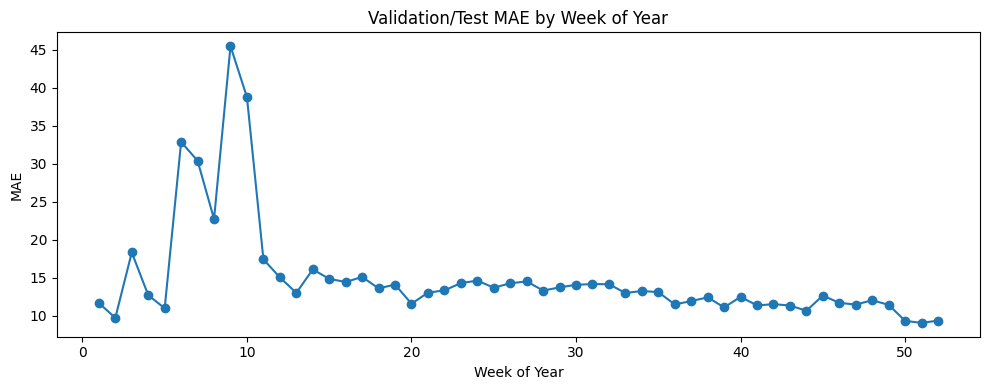

In [34]:
plt.figure(figsize=(10, 4))
plt.plot(by_week["weekofyear"], by_week["mae"], marker="o")
plt.xlabel("Week of Year")
plt.ylabel("MAE")
plt.title("Validation/Test MAE by Week of Year")
plt.tight_layout()
plt.show()


## 중요한 피처 vs 오차 관계

Top feature by gain: lag_1


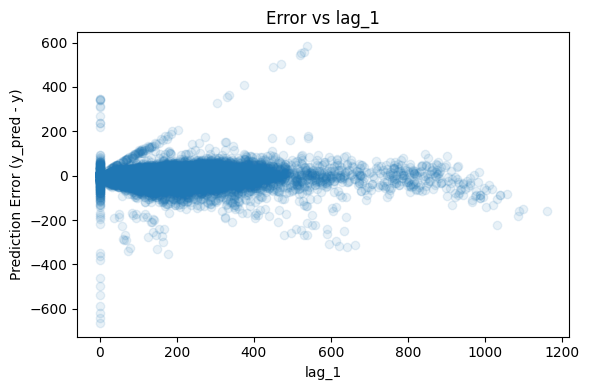

In [35]:
top_feature = imp_gain_df.loc[0, "feature"]
print("Top feature by gain:", top_feature)

plt.figure(figsize=(6, 4))
plt.scatter(test_merged[top_feature], test_merged["error"], alpha=0.1)
plt.xlabel(top_feature)
plt.ylabel("Prediction Error (y_pred - y)")
plt.title(f"Error vs {top_feature}")
plt.tight_layout()
plt.show()
